# Evaluating Finger on Finger-news and Finger-tweets
This notebook contains the code to run first run Finger on a geocorpus and then evaluate its performance. The output are the metrics discussed in the thesis and a error curve plot.

In [1]:
import pandas as pd, numpy as np
# for the toponym resolution evaluation
from geopy.distance import distance
# for plotting the error curves
import matplotlib.pyplot as plt
# for reading in the dataframes properly
import ast

In [42]:
# comment and uncomment to select corpus
#corpus = "fingertweets"
corpus = "fingernews"

## Running Finger on a corpus

My intention is to make Finger a Python package. If it already is, replace the codeblock below with a simple import. Until then, I had to explicitly set the path to the .py files and import it from there (or start a console session in the folder)

In [3]:
import sys
sys.path.insert(0, 'C:/Users/myusername/path/Geoparser_files/')
from geoparser import geoparser

In [4]:
parser = geoparser(gn_username=["my_user_name", "my_second_user_name"],verbose=True, use_gpu=False)

Getting the input texts as a list. Finger is built for batch processing and prefers lists of texts like these.

In [43]:
corp = pd.read_csv("./input_data/{}_gold_df.csv".format(corpus))

inp = corp['input_text'].unique().tolist()

In [44]:
# this is an example of what's given as input – a simple string
print(inp[0])
print(len(inp))

Vuodenvaihteen jälkeen 336 kuntaa – Wikiuutiset
1. tammikuuta 2011
Vuoden alussa tapahtui kuusi kuntaliitosta, joiden jäljiltä Suomessa on 336 kuntaa. Samalla Itä-Uudenmaan maakunta liitettiin Uudenmaan maakuntaan ja Kaakkois-Pirkanmaan seutukunta lakkautettiin, jolloin seutukuntien lukumäärä Suomessa väheni 70:een.
Pirkanmaan kahdessa kuntaliitoksessa Kylmäkoski liittyi Akaan kaupunkiin ja Kuhmalahti Kangasalan kuntaan. Pohjois-Savossa Karttula yhdistyi Kuopion kaupunkiin ja Varpaisjärvi Lapinlahden kuntaan. Pohjanmaan maakunnassa Vöyri-Maksamaan ja Oravaisten kunnat muodostivat Vöyrin kunnan ja Päijät-Hämeessä Artjärvi liittyi osaksi Orimattilaa.

42


In [ ]:
# filter_toponyms = applies a filtering on almost certain false positives (currently just extremely short hits, pretty much always emojis)
# explode_df = each toponym hit is in its own row
res = parser.geoparse(inp, explode_df=True, filter_toponyms=True)

Save the result as a csv (you could probably pickle this, too):

In [11]:
res.to_csv("./input_data/{}_pred_df.csv".format(corpus))

Reading back in a dataframe as from a CSV is a hassle in this case because the data types are all wrong. The codes below should treat them right. The evaluation codes below assume the dataframes are in an "exploded" format, so that each row contains one or zero toponyms, no lists of toponyms/coords. If you want to explode the dataframes posthumously, check the Formatting notebook.

In [45]:
pred_fp = "./input_data/{}_pred_df.csv".format(corpus)

preds = pd.read_csv(pred_fp, index_col=0)
preds.drop("doc", axis=1, inplace=True)
preds.replace([np.nan], [None], inplace=True)
preds['coord_points'] = preds['coord_points'].apply(lambda x: ast.literal_eval(str(x)))
preds['loc_spans'] = preds['loc_spans'].apply(lambda x: ast.literal_eval(str(x)))
preds['coord_points'] = preds['coord_points'].str[0]

gold_fp = "./input_data/{}_gold_df.csv".format(corpus)

golds = pd.read_csv(gold_fp, index_col=0)
golds.replace([np.nan], [None], inplace=True)
golds['coord_points'] = golds['coord_points'].apply(lambda x: ast.literal_eval(str(x)))
golds['loc_spans'] = golds['loc_spans'].apply(lambda x: ast.literal_eval(str(x)))

In [153]:
len(preds[preds['locations_found']])

214

## Evaluation

The evaluation code is heavily inspired by Milan Gritta's code for Gritta et al.'s paper "A pragmatic guide to geoparsing evaluation", [see here](https://github.com/milangritta/WhatsMissingInGeoparsing/blob/master/methods.py).

#### IMPORTANT NOTE: The evaluation code assumes the predictions and golds are in the same order. I know this is a weakness, a better solution could probably be crafted. Eh.

In [167]:
def evaluate_corpus(golds, preds, inspect=False):
    """Inputs: Gold and prediction dataframes that follow Finger's naming conventions.
    
    inspect=print closer examination of some error cause. Give strings to indicate which error to examine. 
    options: recognition, resolve, lemma
    
    Outputs: a list of count of true positives, false positives and false negatives; a list of error distances in km"""
    
    # below are counters
    # true positive
    tp=0
    # false positive
    fp=0
    # false negative
    fn=0
    
    # these are used for error analysis
    missing_pred = 0
    missing_gold = 0
    geocode_results = []
    
    # grouping the exploded 
    gold_groups = golds.groupby('input_order')
    pred_groups = preds.groupby('input_order')
    
    # loop through the groups; because the golds and predictions are in the same order
    # the groups always correspond to the same input documents
    for (g_key, g_group), (p_key, p_group) in zip(gold_groups, pred_groups):
        positive_hits=0
        
        # shorthand code to skip unnecessary processing below
        # while treating all cases the same would've been wise, removing the code below caused trouble
        # if both groups are empty OR either of the groups are empty, while the other is not
        # 1. Both empty: skip further processing
        # 2. Toponyms in gold but not in prediction: add group length to false positives
        # 3. Toponyms in predictopn but not in gold: add group length to false negatives
        if g_group['locations'].loc[g_key] is None and p_group['locations'].loc[p_key] is None:
            continue
        elif g_group['locations'].loc[g_key] is None and p_group['locations'].loc[p_key] is not None:
            if inspect=="recognition":
                try:
                    print("False positives\t", p_group['locations'].loc[p_key].tolist())
                except:
                    print("False positives\t", p_group['locations'].loc[p_key])
            fp += len(p_group)
            continue
        elif g_group['locations'].loc[g_key] is not None and p_group['locations'].loc[p_key] is None:
            if inspect=="recognition":
                try:
                    print("False negatives\t", g_group['locations'].loc[g_key].tolist())
                except:
                    print("False negatives\t", g_group['locations'].loc[g_key])

            fn += len(g_group)
            continue


        # if both have toponyms,try to find matches by spans and toponym texts
        for g_location, g_span, g_coord in zip(g_group['locations'], g_group['loc_spans'], g_group['coord_points']):
            match=False
            fn_flag = False


            # for each gold toponym, loop through predictions
            # if matches, raise a flag and add to positive matches on this loop
            for p_location, p_lemma, p_span, p_coord in zip(p_group['locations'],p_group['loc_lemmas'], p_group['loc_spans'], p_group['coord_points']):


                # get the mean position of the spans
                mean_g_span = sum(g_span) / 2
                mean_p_span = sum(p_span) / 2

                # if the toponym strings match AND the mean of the spans spans are within 4 numbers, marks as match
                # I noticed emojis caused some weird inconsistencies in the gold vs pred spans
                # which is why exact span isn't used
                if abs(mean_g_span - mean_p_span) <= 4 and g_location.lower() == p_location.lower():
                    match=True
                    positive_hits += 1

                    if g_coord:
                        if p_coord:
                            # lonlat -> latlon
                            # because that format used by geopy
                            # BTW, this is geodesic distance on the default WGS84 ellipsoid
                            p_coord = tuple(reversed(p_coord))
                            g_coord = tuple(reversed(g_coord))

                            error_distance = distance(p_coord, g_coord).kilometers
                            
                            if inspect=="resolve":
                                if error_distance > 1:
                                    print("ERROR DISTANCE:\t",p_lemma, round(error_distance,1), g_location)

                            geocode_results.append(error_distance)
                            """
                            if inspect=="lemma":
                                print(p_lemma, round(error_distance,1), g_location)
                            """

                        else:
                            missing_pred += 1
                            
                            if inspect=="resolve" or inspect=="lemma":
                                print("Prediction missing:\t", p_lemma, "Gold is:", g_location)

            if match:
                tp += 1
            else:
                fn += 1
                if inspect=="recognition":
                    reach = 30
                    if int(g_span[0])-reach < 0:
                        st = 0
                    else:
                        st = int(g_span[0])-reach
                    if int(g_span[1])+reach > len( g_group['input_text'].iloc[0]):
                        ed = len( g_group['input_text'].iloc[0])
                    else:
                        ed = int(g_span[1])+reach
                    
                    print(fn, "No matching pred found for gold:", g_location, "\n", g_group['input_text'].iloc[0][st:ed])
                    print("Options:", p_group['locations'].tolist())
                    print("Golds:", g_group['locations'].tolist(), "\n")
                
        if positive_hits < len(p_group):
            fp += len(p_group) - positive_hits

    print(tp, "true positives")
    print(fp, "false positives")
    print(fn, "false negatives")

    print(missing_pred, "lemma/geocode loss. In % resolved:", 100 - round(((missing_pred)/tp)*100,2))
    
    scores = [tp, fp, fn]
    
    return scores, geocode_results

In [169]:
scores, geocode_results = evaluate_corpus(golds, preds, inspect="none")

150 true positives
64 false positives
39 false negatives
27 lemma/geocode loss. In % resolved: 82.0


### Calculating and printing toponym recognition metrics:

In [170]:
precision = scores[0] / (scores[0] + scores[1])
print("Precision: ", precision)
recall = scores[0] / (scores[0] + scores[2])
print("Recall:    ", recall)
f_score = 2 * precision * recall / (precision + recall)
print("F-Score:   ", f_score)

Precision:  0.7009345794392523
Recall:     0.7936507936507936
F-Score:    0.7444168734491315


### Calculating and printing toponym resolution metrics:

In [171]:
MAX_ERROR = 20039

print("Median: ", np.median(sorted(geocode_results)))
print("Mean: ", np.mean(geocode_results))
k = 161  # This is the k in accuracy@k metric
print("Accuracy to 161 km: ", sum([1.0 for dist in geocode_results if dist < k]) / len(geocode_results))

# if there was no error (Error Distance = 0 km), 1 is appended to the value to make natural log possible -> else an error
auc_geocode_results = [dist_error + 1 if dist_error < 1 else dist_error for dist_error in geocode_results]
print("AUC = ", np.trapz(np.log(auc_geocode_results)) / (np.log(MAX_ERROR) * (len(auc_geocode_results) - 1)))

Median:  0.0
Mean:  286.13639446305405
Accuracy to 161 km:  0.9166666666666666
AUC =  0.08292499035439962


#### Alternatively, here's a function that writes out the results in a nice text file

In [53]:
def write_results_to_file(scores, geocode_results, corpus, k, round_value):
    fp = "./eval_output/{}_evaluation_results.txt".format(corpus)
    precision = round(scores[0] / (scores[0] + scores[1]),round_value)
    recall = round(scores[0] / (scores[0] + scores[2]),round_value)
    f_score = round(2 * precision * recall / (precision + recall),round_value)
    
    median_err = round(np.median(sorted(geocode_results)),round_value)
    mean_err = round(np.mean(geocode_results),round_value)
    acc_k = round(sum([1.0 for dist in geocode_results if dist < k]) / len(geocode_results),round_value)
    auc_geocode_results = [dist_error + 1 if dist_error < 1 else dist_error for dist_error in geocode_results]
    AUC = round(np.trapz(np.log(auc_geocode_results)) / (np.log(MAX_ERROR) * (len(auc_geocode_results) - 1)),round_value)
    
    with open(fp, 'w', encoding='utf-8') as f:
        f.write("Results for {}".format(corpus))
        f.write("\n")
        
        f.write("Precision: {}".format(precision))
        f.write("\n")
        f.write("Recall: {}".format(recall))
        f.write("\n")
        f.write("F-Score: {}".format(f_score))
        f.write("\n")
         
        f.write("Median: {}".format(median_err))
        f.write("\n")
        f.write("Mean: {}".format(mean_err))
        f.write("\n")
        f.write("Accuracy to {0} km: {1}".format(k, acc_k))
        f.write("\n")
        f.write("AUC = {}".format(AUC))
        
        f.close()

In [54]:
write_results_to_file(scores, geocode_results, corpus, k=161, round_value=3)

### Plotting the error distances

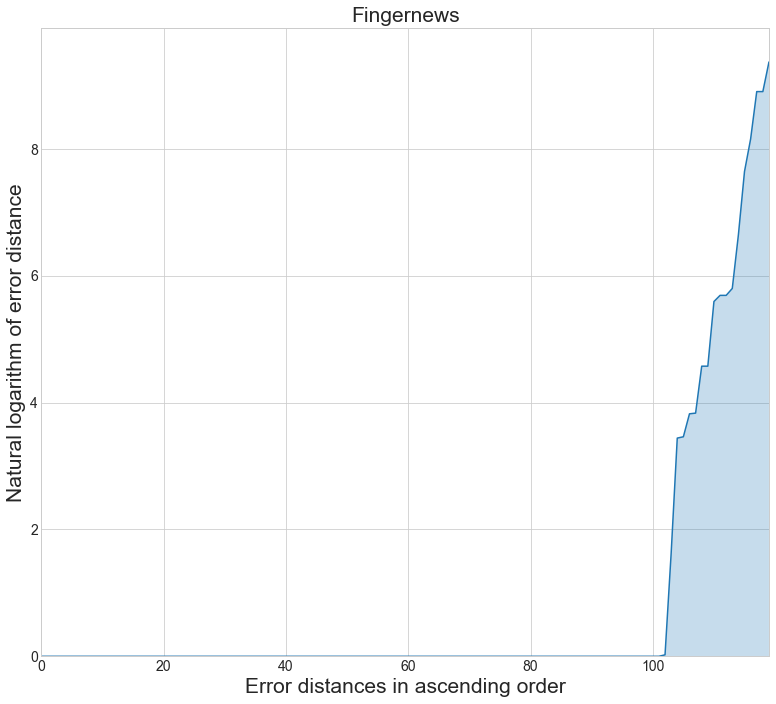

In [55]:
# font sizes for different types of texts
SMALL_SIZE = 14
MEDIUM_SIZE = 21

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.style.use('seaborn-whitegrid')

fig = plt.plot((sorted(np.log(auc_geocode_results))))
plt.rcParams["figure.figsize"] = (11,10)

#plt.title('Distribution of geocoding errors in {}.\nNumber of toponyms: {}'.format(corpus,str(len(auc_geocode_results))))
plt.title(corpus.capitalize())
plt.ylabel('Natural logarithm of error distance')
plt.xlabel('Error distances in ascending order')

count_list = []
count_list.extend(range(0,len(geocode_results)))

plt.fill_between(count_list,(sorted(np.log(auc_geocode_results))), alpha=0.25)

plt.xlim([0,len(geocode_results)-1])
# y limit is the max possible error
plt.ylim([0,np.log(20039)])


#plt.show()

plt.tight_layout()

plt.savefig("./eval_output/{}_AUC_plot.png".format(corpus))